In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import os
from keras.utils import  to_categorical 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, MaxPool2D, Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.callbacks import EarlyStopping

data:

In [3]:
d = tf.keras.utils.image_dataset_from_directory('IMGS', batch_size=5) 
data = d.map(lambda x,y: (x/255,y))
data.as_numpy_iterator().next()

Found 2750 files belonging to 6 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(array([[[[2.94117659e-01, 1.21568628e-01, 1.25490203e-01],
          [5.41176498e-01, 3.09803933e-01, 2.39215687e-01],
          [5.56862772e-01, 2.98039228e-01, 2.11764708e-01],
          ...,
          [1.96078438e-02, 1.56862754e-02, 7.84313772e-03],
          [3.13725501e-01, 2.15686277e-01, 5.88235296e-02],
          [5.01960814e-01, 3.45098048e-01, 1.41176477e-01]],
 
         [[2.11764708e-01, 1.01960786e-01, 9.01960805e-02],
          [4.43137258e-01, 2.35294119e-01, 1.64705887e-01],
          [5.76470613e-01, 3.09803933e-01, 2.27450982e-01],
          ...,
          [1.96078438e-02, 2.35294122e-02, 3.92156877e-02],
          [2.58823544e-01, 1.45098045e-01, 8.23529437e-02],
          [4.90196079e-01, 3.21568638e-01, 1.13725491e-01]],
 
         [[2.15686277e-01, 1.33333340e-01, 1.21568628e-01],
          [3.68627459e-01, 2.03921571e-01, 1.49019614e-01],
          [5.60784340e-01, 3.05882365e-01, 2.19607845e-01],
          ...,
          [3.52941193e-02, 3.92156877e-02, 7.8431

In [59]:
train_size = int(len(data)*.8) 
test_size = int(len(data)*.2) 

In [60]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)

In [61]:
Y_train = np.concatenate([y for x, y in train], axis=0)
X_train = np.concatenate([x for x, y in train], axis=0)
Y_test = np.concatenate([y for x, y in test], axis=0)
X_test = np.concatenate([x for x, y in test], axis=0)

In [62]:
Y_train_cat = to_categorical(Y_train)
Y_test_cat = to_categorical(Y_test)

In [63]:
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    height_shift_range = 0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    zoom_range = 0.4,
    horizontal_flip = True,
    fill_mode='reflect',
)

In [66]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(
    X_train,
    Y_train_cat,
    batch_size = 16)

In [67]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    X_test,
    Y_test_cat,
    batch_size = 8)

# INCEPTION-V3 Model:

In [11]:
I_model = InceptionV3(input_shape = (256,256,3) , include_top = False, weights='imagenet')

87910968/87910968 [==============================] - 7s 0us/step


In [68]:
print("layer count: %d" %len(I_model.layers))

layer count: 311


In [17]:
for layer in I_model.layers:
    layer.trainable = False

In [23]:
x = I_model.output

In [24]:
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation = 'softmax')(x)

model = Model(I_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

C:\Users\revie\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [26]:
usualCallback = EarlyStopping()
overfitCallback = EarlyStopping(monitor='loss', min_delta=0, patience = 5)

In [27]:
train_generator.n//train_generator.batch_size

15

In [69]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>0.99):
            print('\nReached 99.9%, so canceling training')
            self.model.stop_training = True

In [71]:
history = model.fit_generator(generator= train_generator,
                   #steps_per_epoch=100,
                                 validation_data = test_generator,
                   epochs=20, callbacks=[overfitCallback])

C:\Users\revie\AppData\Local\Temp\ipykernel_14376\3274783125.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator= train_generator,


Epoch 1/20
138/138 [==============================] - 159s 1s/step - loss: 2.4396 - accuracy: 0.1705 - val_loss: 3.3297 - val_accuracy: 0.1855
Epoch 2/20
138/138 [==============================] - 160s 1s/step - loss: 1.8626 - accuracy: 0.2009 - val_loss: 2.6559 - val_accuracy: 0.1745
Epoch 3/20
138/138 [==============================] - 163s 1s/step - loss: 1.8200 - accuracy: 0.2023 - val_loss: 2.8216 - val_accuracy: 0.1709
Epoch 4/20
138/138 [==============================] - 162s 1s/step - loss: 1.8026 - accuracy: 0.2200 - val_loss: 2.9016 - val_accuracy: 0.1709
Epoch 5/20
138/138 [==============================] - 159s 1s/step - loss: 1.7883 - accuracy: 0.2345 - val_loss: 3.0604 - val_accuracy: 0.1927
Epoch 6/20
138/138 [==============================] - 160s 1s/step - loss: 1.7440 - accuracy: 0.2623 - val_loss: 3.3145 - val_accuracy: 0.1527
Epoch 7/20
138/138 [==============================] - 160s 1s/step - loss: 1.7398 - accuracy: 0.2800 - val_loss: 3.1103 - val_accuracy: 0.1655

# + transfer learning

In [40]:
I_model.layers

In [72]:
last_layer = I_model.get_layer('mixed7')
last_output = last_layer.output

In [45]:
x = Flatten()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation = 'softmax')(x)

model = Model(I_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [47]:
callbacks = myCallback()

In [ ]:
history = model.fit_generator(generator= train_generator,
                   #steps_per_epoch=100,
                                 validation_data = test_generator,
                   epochs=100, callbacks=[callbacks])

In [48]:
history = model.fit_generator(generator= train_generator,
                   #steps_per_epoch=100,
                                 validation_data = test_generator,
                   epochs=100, callbacks=[callbacks])

Epoch 1/100


C:\Users\revie\AppData\Local\Temp\ipykernel_14376\2090714247.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator= train_generator,


60/60 [==============================] - 63s 976ms/step - loss: 2.3774 - accuracy: 0.1604 - val_loss: 2.0023 - val_accuracy: 0.1333
Epoch 2/100
60/60 [==============================] - 54s 902ms/step - loss: 1.8985 - accuracy: 0.2625 - val_loss: 2.0826 - val_accuracy: 0.1500
Epoch 3/100
60/60 [==============================] - 53s 885ms/step - loss: 1.7455 - accuracy: 0.3229 - val_loss: 2.2666 - val_accuracy: 0.1250
Epoch 4/100
60/60 [==============================] - 53s 882ms/step - loss: 1.6012 - accuracy: 0.4167 - val_loss: 2.2426 - val_accuracy: 0.1417
Epoch 5/100
60/60 [==============================] - 55s 920ms/step - loss: 1.4495 - accuracy: 0.4542 - val_loss: 2.7980 - val_accuracy: 0.1417
Epoch 6/100
60/60 [==============================] - 54s 898ms/step - loss: 1.2944 - accuracy: 0.5271 - val_loss: 3.2983 - val_accuracy: 0.1417
Epoch 7/100
60/60 [==============================] - 54s 899ms/step - loss: 1.1195 - accuracy: 0.5896 - val_loss: 2.8998 - val_accuracy: 0.1250
Epoc

4/4 [==============================] - 3s 647ms/step


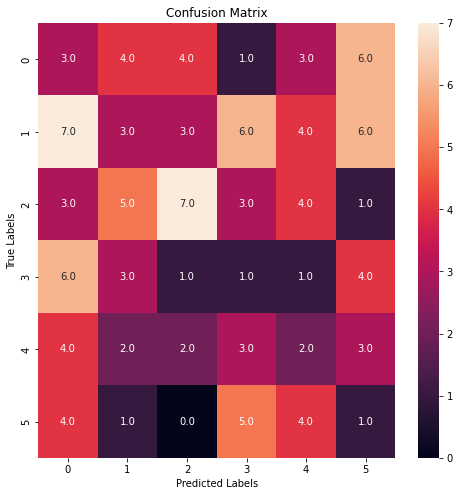

In [51]:
test_pred_2 = model.predict(X_test)
test_predicted_2 = np.argmax(test_pred_2, axis = 1)
test_true = np.argmax(Y_test_cat, axis = 1)
confmx = confusion_matrix(test_predicted_2, test_true)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

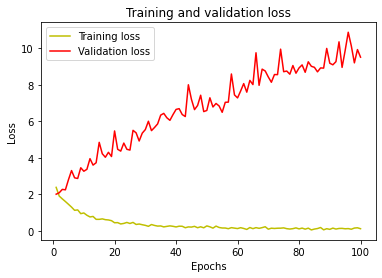

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

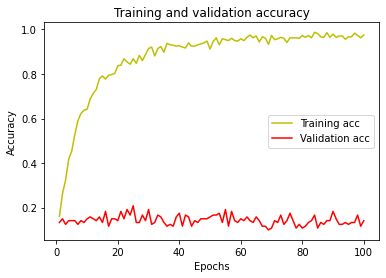

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [55]:
model.save('model_inceptionv3.h5')